In [1]:
import torch
import torchvision
from torchvision import transforms
import torch.nn as nn

import matplotlib.pyplot as plt

import numpy as np

from common import *

torch.manual_seed(42)

In [2]:
!pip install wandb

import wandb

wandb.login()

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 61.9 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.0/163.0 kB 31.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 140.4/140.4 kB 6.5 MB/s eta 0:00:00
  Created wheel for promise: filename=promise-2.3-py3-none-any.whl size=21486 sha256=0ff662e5d599dc88c11f9849f9de7ac7dd110eafe917ab9e3f94984636f419ff
  Stored in directory: /root/.cache/pip/wheels/e1/e8/83/ddea66100678d139b14bc87692ece57c6a2a937956d2532608
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=7cd9e79a7ec2b95451a9b101493564454926247346fcffd751703f5ef9c97181
  Stored in directory: /root/.cache/pip/wheels/b7/0a/67/ada2a22079218c75a88361c0782855cc72aebc4d18d0289d05
Successfully built promise pathtools
  Attempting uninstall: urllib3
    Found existing installation: urllib3 1.26.10
    Uninstalling urllib3-1.26.10:
      

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

  ········································


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


True

In [3]:
train_dataloader, val_dataloader = get_dataloaders() # From common.py

# What We're Building

(Modified from the original source: https://lmb.informatik.uni-freiburg.de/people/ronneber/u-net/)

![](./u-net-architecture-edit.png)

In [4]:
class ConvBlock(nn.Module):
    def __init__(self, f_in : int, f_out : int):
        super().__init__()
        
        self.convs = nn.Sequential(
            nn.Conv2d(
                in_channels=f_in,
                out_channels=f_out,
                kernel_size = (3, 3),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=f_out,
                out_channels=f_out,
                kernel_size = (3, 3),
                padding = 'same',
                bias=False # Batch norm makes bias pointless
            ),
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.convs(x)

    
    
class UpConv(nn.Module):
    def __init__(self, f_in : int, f_out : int):
        super().__init__()
        
        self.up = nn.Upsample(scale_factor=2, mode='bilinear')
        self.conv = nn.Sequential(
            nn.Conv2d(
                in_channels = f_in,
                out_channels = f_out,
                kernel_size = (2, 2),
                padding = 'same'
            ),
            # Not sure if these make sense but testing
            nn.BatchNorm2d(num_features=f_out),
            nn.ReLU(),
        )
    
    def forward(self, x):
        y = self.up(x)
        y = self.conv(y)
        
        return y

    
class UNet(nn.Module):
    def __init__(self, channels : int, classes : int):
        super().__init__()
        
        # (A)
        self.c1 = ConvBlock(channels, 64)
        self.mp1 = nn.MaxPool2d(2)
        
        # (B)
        self.c2 = ConvBlock(64, 128)
        self.mp2 = nn.MaxPool2d(2)
        
        # (C)
        self.c3 = ConvBlock(128, 256)
        self.mp3 = nn.MaxPool2d(2) # 🎵
        
        # (D)
        self.c4 = ConvBlock(256, 512) # 💣
        self.mp4 = nn.MaxPool2d(2) # 📼
        
        # (E)
        self.c5 = ConvBlock(512, 1024)
        self.up1 = UpConv(1024, 512)
        
        # (F)
        self.c6 = ConvBlock(1024, 512)
        self.up2 = UpConv(512, 256)
        
        # (G)
        self.c7 = ConvBlock(512, 256)
        self.up3 = UpConv(256, 128)
        
        # (H)
        self.c8 = ConvBlock(256, 128)
        self.up4 = UpConv(128, 64)
        
        # (I)
        self.c9 = ConvBlock(128, 64)
        self.c_final = nn.Conv2d(
            in_channels = 64,
            out_channels = classes,
            kernel_size = (1, 1),
            stride = 1,
            padding = 'same'
        )
    
    def forward(self, x):
        # (A)
        y = self.c1(x)
        skip1 = y
        y = self.mp1(y) # 64 x 64
        
        # (B)
        y = self.c2(y)
        skip2 = y
        y = self.mp2(y) # 32 x 32
        
        # (C)
        y = self.c3(y)
        skip3 = y
        y = self.mp3(y) # 16 x 16
        
        # (D)
        y = self.c4(y)
        skip4 = y
        y = self.mp4(y) # 8 x 8
        
        # (E)
        y = self.c5(y)
        y = self.up1(y) # 16 x 16
        
        y = torch.cat((skip4, y), dim=1) # [batch, channels, x, y]
        
        # (F)
        y = self.c6(y)
        y = self.up2(y)
        
        y = torch.cat((skip3, y), dim=1)
        
        # (G)
        y = self.c7(y)
        y = self.up3(y)
        
        y = torch.cat((skip2, y), dim=1)
        
        # (H)
        y = self.c8(y)
        y = self.up4(y)
        
        y = torch.cat((skip1, y), dim=1)
        
        # (I)
        y = self.c9(y)
        y = self.c_final(y)
        
        # Done
        return y

In [5]:
# Define a training loop

hp = {
    'lr': 1e-2,
    'batch_size': 64,
    'epochs': 50
}

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

model = UNet(
    channels=3,
    classes=2
).to(device)

loss_fn =  nn.CrossEntropyLoss()

optimizer = torch.optim.SGD(model.parameters(), lr=hp['lr'])

Using cuda device


In [6]:
wandb.init(project="unet-streams", group="original", config = hp)

wandb: Currently logged in as: elliotcsmith. Use `wandb login --relogin` to force relogin


============= Epoch 0 ===============


/usr/local/lib/python3.9/dist-packages/torch/nn/modules/conv.py:453: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at  ../aten/src/ATen/native/Convolution.cpp:882.)
  return F.conv2d(input, weight, bias, self.stride,


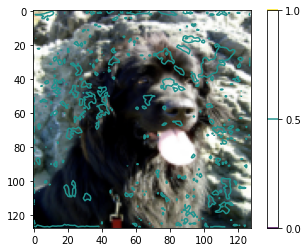

Mean batch loss on validation set: 0.857462 dice: 0.386714
loss: 0.861116 [    0/ 2944]
loss: 0.724859 [  320/ 2944]
loss: 0.648547 [  640/ 2944]
loss: 0.604963 [  960/ 2944]
loss: 0.570081 [ 1280/ 2944]
loss: 0.549748 [ 1600/ 2944]
loss: 0.514050 [ 1920/ 2944]
loss: 0.482746 [ 2240/ 2944]
loss: 0.445189 [ 2560/ 2944]
loss: 0.426861 [ 2880/ 2944]
============= Epoch 1 ===============


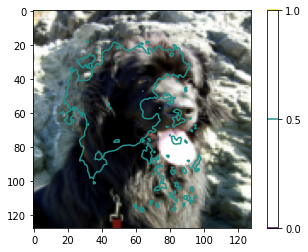

Mean batch loss on validation set: 0.450910 dice: 0.488571
loss: 0.448528 [    0/ 2944]
loss: 0.423777 [  320/ 2944]
loss: 0.429465 [  640/ 2944]
loss: 0.410863 [  960/ 2944]
loss: 0.393177 [ 1280/ 2944]
loss: 0.403890 [ 1600/ 2944]
loss: 0.428141 [ 1920/ 2944]
loss: 0.392567 [ 2240/ 2944]
loss: 0.362552 [ 2560/ 2944]
loss: 0.363242 [ 2880/ 2944]
============= Epoch 2 ===============


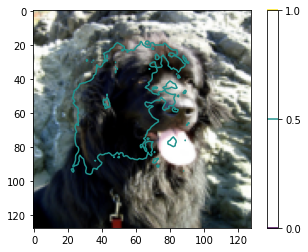

Mean batch loss on validation set: 0.385577 dice: 0.562977
loss: 0.391207 [    0/ 2944]
loss: 0.365893 [  320/ 2944]
loss: 0.374957 [  640/ 2944]
loss: 0.355541 [  960/ 2944]
loss: 0.336978 [ 1280/ 2944]
loss: 0.359383 [ 1600/ 2944]
loss: 0.396321 [ 1920/ 2944]
loss: 0.353997 [ 2240/ 2944]
loss: 0.334394 [ 2560/ 2944]
loss: 0.340032 [ 2880/ 2944]
============= Epoch 3 ===============


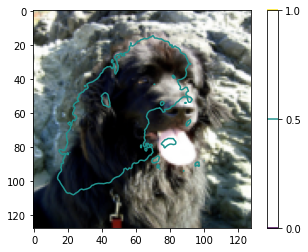

Mean batch loss on validation set: 0.360649 dice: 0.597875
loss: 0.349569 [    0/ 2944]
loss: 0.334005 [  320/ 2944]
loss: 0.343692 [  640/ 2944]
loss: 0.333784 [  960/ 2944]
loss: 0.312250 [ 1280/ 2944]
loss: 0.341442 [ 1600/ 2944]
loss: 0.364054 [ 1920/ 2944]
loss: 0.336619 [ 2240/ 2944]
loss: 0.318023 [ 2560/ 2944]
loss: 0.323622 [ 2880/ 2944]
============= Epoch 4 ===============


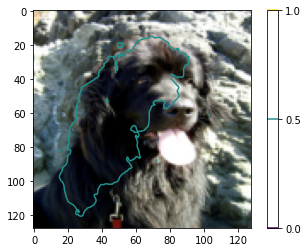

Mean batch loss on validation set: 0.344781 dice: 0.620499
loss: 0.338035 [    0/ 2944]
loss: 0.314363 [  320/ 2944]
loss: 0.323799 [  640/ 2944]
loss: 0.309649 [  960/ 2944]
loss: 0.290925 [ 1280/ 2944]
loss: 0.337416 [ 1600/ 2944]
loss: 0.346403 [ 1920/ 2944]
loss: 0.312867 [ 2240/ 2944]
loss: 0.296890 [ 2560/ 2944]
loss: 0.310989 [ 2880/ 2944]
============= Epoch 5 ===============


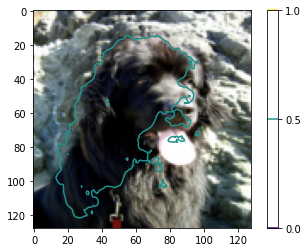

Mean batch loss on validation set: 0.332444 dice: 0.637710
loss: 0.313148 [    0/ 2944]
loss: 0.300660 [  320/ 2944]
loss: 0.313940 [  640/ 2944]
loss: 0.293525 [  960/ 2944]
loss: 0.296034 [ 1280/ 2944]
loss: 0.324920 [ 1600/ 2944]
loss: 0.352027 [ 1920/ 2944]
loss: 0.295038 [ 2240/ 2944]
loss: 0.283758 [ 2560/ 2944]
loss: 0.287276 [ 2880/ 2944]
============= Epoch 6 ===============


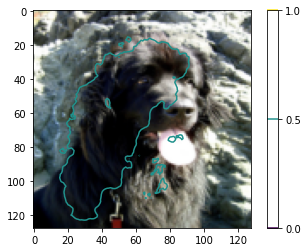

Mean batch loss on validation set: 0.320705 dice: 0.653117
loss: 0.316710 [    0/ 2944]
loss: 0.290993 [  320/ 2944]
loss: 0.289098 [  640/ 2944]
loss: 0.273673 [  960/ 2944]
loss: 0.272123 [ 1280/ 2944]
loss: 0.310068 [ 1600/ 2944]
loss: 0.320126 [ 1920/ 2944]
loss: 0.292947 [ 2240/ 2944]
loss: 0.271335 [ 2560/ 2944]
loss: 0.283274 [ 2880/ 2944]
============= Epoch 7 ===============


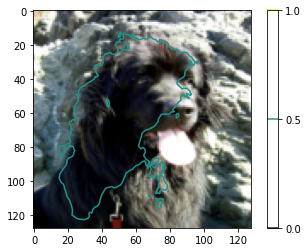

Mean batch loss on validation set: 0.312247 dice: 0.665762
loss: 0.291128 [    0/ 2944]
loss: 0.282928 [  320/ 2944]
loss: 0.291506 [  640/ 2944]
loss: 0.259475 [  960/ 2944]
loss: 0.260672 [ 1280/ 2944]
loss: 0.301644 [ 1600/ 2944]
loss: 0.324287 [ 1920/ 2944]
loss: 0.281894 [ 2240/ 2944]
loss: 0.256759 [ 2560/ 2944]
loss: 0.290964 [ 2880/ 2944]
============= Epoch 8 ===============


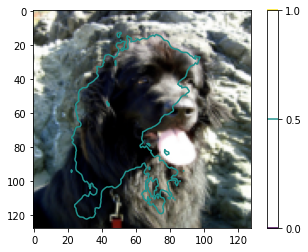

Mean batch loss on validation set: 0.307122 dice: 0.674397
loss: 0.273140 [    0/ 2944]
loss: 0.269069 [  320/ 2944]
loss: 0.291966 [  640/ 2944]
loss: 0.255713 [  960/ 2944]
loss: 0.249295 [ 1280/ 2944]
loss: 0.294661 [ 1600/ 2944]
loss: 0.310880 [ 1920/ 2944]
loss: 0.282421 [ 2240/ 2944]
loss: 0.268807 [ 2560/ 2944]
loss: 0.278060 [ 2880/ 2944]
============= Epoch 9 ===============


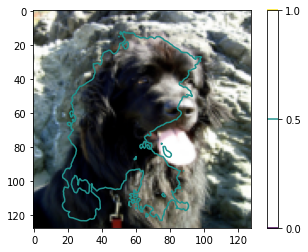

Mean batch loss on validation set: 0.299224 dice: 0.683093
loss: 0.263205 [    0/ 2944]
loss: 0.258205 [  320/ 2944]
loss: 0.260034 [  640/ 2944]
loss: 0.251278 [  960/ 2944]
loss: 0.242397 [ 1280/ 2944]
loss: 0.283783 [ 1600/ 2944]
loss: 0.299536 [ 1920/ 2944]
loss: 0.259806 [ 2240/ 2944]
loss: 0.254075 [ 2560/ 2944]
loss: 0.264852 [ 2880/ 2944]
============= Epoch 10 ===============


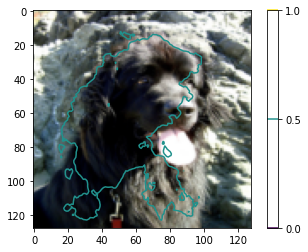

Mean batch loss on validation set: 0.291426 dice: 0.692297
loss: 0.251366 [    0/ 2944]
loss: 0.249718 [  320/ 2944]
loss: 0.275692 [  640/ 2944]
loss: 0.241502 [  960/ 2944]
loss: 0.232326 [ 1280/ 2944]
loss: 0.263562 [ 1600/ 2944]
loss: 0.292508 [ 1920/ 2944]
loss: 0.257850 [ 2240/ 2944]
loss: 0.239673 [ 2560/ 2944]
loss: 0.250277 [ 2880/ 2944]
============= Epoch 11 ===============


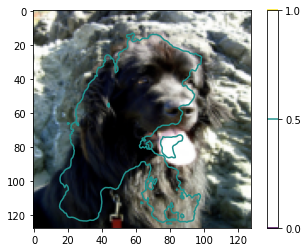

Mean batch loss on validation set: 0.285251 dice: 0.700955
loss: 0.232316 [    0/ 2944]
loss: 0.227157 [  320/ 2944]
loss: 0.270600 [  640/ 2944]
loss: 0.226427 [  960/ 2944]
loss: 0.228636 [ 1280/ 2944]
loss: 0.252985 [ 1600/ 2944]
loss: 0.278213 [ 1920/ 2944]
loss: 0.249440 [ 2240/ 2944]
loss: 0.229588 [ 2560/ 2944]
loss: 0.242834 [ 2880/ 2944]
============= Epoch 12 ===============


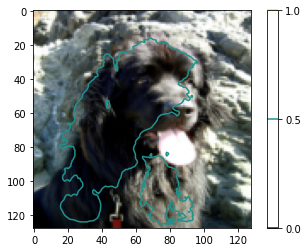

Mean batch loss on validation set: 0.285165 dice: 0.705332
loss: 0.258740 [    0/ 2944]
loss: 0.245757 [  320/ 2944]
loss: 0.227848 [  640/ 2944]
loss: 0.213103 [  960/ 2944]
loss: 0.218173 [ 1280/ 2944]
loss: 0.241012 [ 1600/ 2944]
loss: 0.260131 [ 1920/ 2944]
loss: 0.253169 [ 2240/ 2944]
loss: 0.228693 [ 2560/ 2944]
loss: 0.251516 [ 2880/ 2944]
============= Epoch 13 ===============


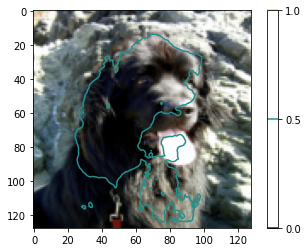

Mean batch loss on validation set: 0.281554 dice: 0.710480
loss: 0.244469 [    0/ 2944]
loss: 0.216843 [  320/ 2944]
loss: 0.248346 [  640/ 2944]
loss: 0.212130 [  960/ 2944]
loss: 0.209442 [ 1280/ 2944]
loss: 0.239881 [ 1600/ 2944]
loss: 0.278319 [ 1920/ 2944]
loss: 0.238980 [ 2240/ 2944]
loss: 0.222082 [ 2560/ 2944]
loss: 0.232443 [ 2880/ 2944]
============= Epoch 14 ===============


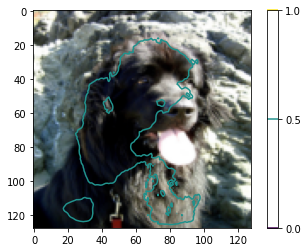

Mean batch loss on validation set: 0.278426 dice: 0.714881
loss: 0.237461 [    0/ 2944]
loss: 0.214998 [  320/ 2944]
loss: 0.248956 [  640/ 2944]
loss: 0.228755 [  960/ 2944]
loss: 0.211558 [ 1280/ 2944]
loss: 0.230225 [ 1600/ 2944]
loss: 0.276344 [ 1920/ 2944]
loss: 0.229832 [ 2240/ 2944]
loss: 0.212630 [ 2560/ 2944]
loss: 0.233086 [ 2880/ 2944]
============= Epoch 15 ===============


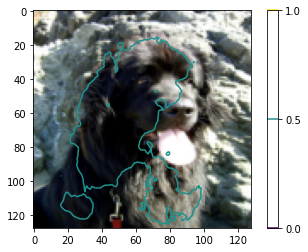

Mean batch loss on validation set: 0.275082 dice: 0.720608
loss: 0.214863 [    0/ 2944]
loss: 0.194512 [  320/ 2944]
loss: 0.232529 [  640/ 2944]
loss: 0.212483 [  960/ 2944]
loss: 0.207843 [ 1280/ 2944]
loss: 0.242299 [ 1600/ 2944]
loss: 0.238476 [ 1920/ 2944]
loss: 0.211049 [ 2240/ 2944]
loss: 0.216894 [ 2560/ 2944]
loss: 0.222961 [ 2880/ 2944]
============= Epoch 16 ===============


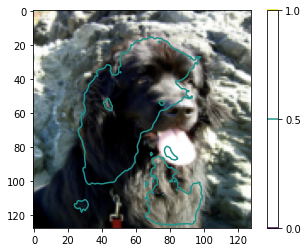

Mean batch loss on validation set: 0.273692 dice: 0.724165
loss: 0.209525 [    0/ 2944]
loss: 0.229343 [  320/ 2944]
loss: 0.226560 [  640/ 2944]
loss: 0.195931 [  960/ 2944]
loss: 0.193229 [ 1280/ 2944]
loss: 0.225419 [ 1600/ 2944]
loss: 0.244585 [ 1920/ 2944]
loss: 0.207181 [ 2240/ 2944]
loss: 0.222552 [ 2560/ 2944]
loss: 0.214325 [ 2880/ 2944]
============= Epoch 17 ===============


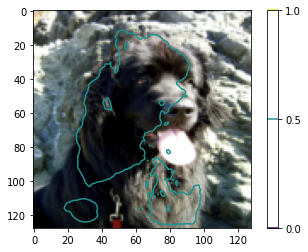

Mean batch loss on validation set: 0.269968 dice: 0.729748
loss: 0.206549 [    0/ 2944]
loss: 0.206023 [  320/ 2944]
loss: 0.225167 [  640/ 2944]
loss: 0.209315 [  960/ 2944]
loss: 0.195496 [ 1280/ 2944]
loss: 0.228164 [ 1600/ 2944]
loss: 0.252718 [ 1920/ 2944]
loss: 0.186271 [ 2240/ 2944]
loss: 0.211060 [ 2560/ 2944]
loss: 0.225208 [ 2880/ 2944]
============= Epoch 18 ===============


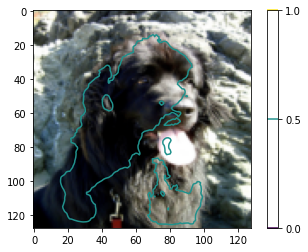

Mean batch loss on validation set: 0.271403 dice: 0.731085
loss: 0.222072 [    0/ 2944]
loss: 0.202036 [  320/ 2944]
loss: 0.216590 [  640/ 2944]
loss: 0.207297 [  960/ 2944]
loss: 0.193151 [ 1280/ 2944]
loss: 0.208895 [ 1600/ 2944]
loss: 0.236674 [ 1920/ 2944]
loss: 0.206130 [ 2240/ 2944]
loss: 0.191270 [ 2560/ 2944]
loss: 0.217530 [ 2880/ 2944]
============= Epoch 19 ===============


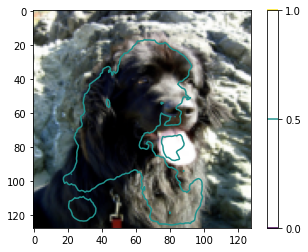

Mean batch loss on validation set: 0.270453 dice: 0.736536
loss: 0.193083 [    0/ 2944]
loss: 0.197054 [  320/ 2944]
loss: 0.213775 [  640/ 2944]
loss: 0.195200 [  960/ 2944]
loss: 0.177321 [ 1280/ 2944]
loss: 0.227854 [ 1600/ 2944]
loss: 0.241053 [ 1920/ 2944]
loss: 0.218851 [ 2240/ 2944]
loss: 0.187522 [ 2560/ 2944]
loss: 0.183091 [ 2880/ 2944]
============= Epoch 20 ===============


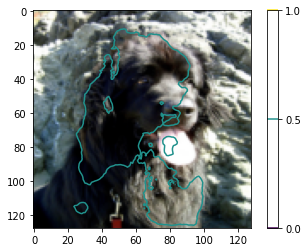

Mean batch loss on validation set: 0.265007 dice: 0.742202
loss: 0.183081 [    0/ 2944]
loss: 0.209044 [  320/ 2944]
loss: 0.201057 [  640/ 2944]
loss: 0.194292 [  960/ 2944]
loss: 0.183675 [ 1280/ 2944]
loss: 0.230284 [ 1600/ 2944]
loss: 0.237890 [ 1920/ 2944]
loss: 0.194426 [ 2240/ 2944]
loss: 0.190413 [ 2560/ 2944]
loss: 0.198911 [ 2880/ 2944]
============= Epoch 21 ===============


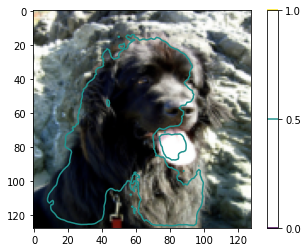

Mean batch loss on validation set: 0.270265 dice: 0.738214
loss: 0.202168 [    0/ 2944]
loss: 0.197424 [  320/ 2944]
loss: 0.199858 [  640/ 2944]
loss: 0.198549 [  960/ 2944]
loss: 0.195691 [ 1280/ 2944]
loss: 0.195306 [ 1600/ 2944]
loss: 0.224715 [ 1920/ 2944]
loss: 0.209064 [ 2240/ 2944]
loss: 0.176558 [ 2560/ 2944]
loss: 0.204531 [ 2880/ 2944]
============= Epoch 22 ===============


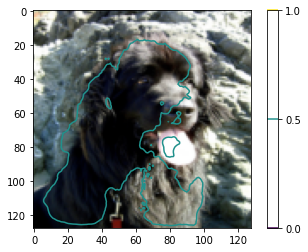

Mean batch loss on validation set: 0.268936 dice: 0.743812
loss: 0.186024 [    0/ 2944]
loss: 0.169170 [  320/ 2944]
loss: 0.191415 [  640/ 2944]
loss: 0.173639 [  960/ 2944]
loss: 0.167779 [ 1280/ 2944]
loss: 0.180869 [ 1600/ 2944]
loss: 0.220478 [ 1920/ 2944]
loss: 0.180523 [ 2240/ 2944]
loss: 0.172449 [ 2560/ 2944]
loss: 0.218741 [ 2880/ 2944]
============= Epoch 23 ===============


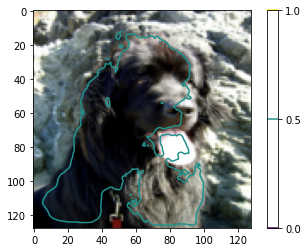

Mean batch loss on validation set: 0.274516 dice: 0.743341
loss: 0.181604 [    0/ 2944]
loss: 0.200822 [  320/ 2944]
loss: 0.191233 [  640/ 2944]
loss: 0.184527 [  960/ 2944]
loss: 0.171838 [ 1280/ 2944]
loss: 0.187306 [ 1600/ 2944]
loss: 0.212894 [ 1920/ 2944]
loss: 0.176417 [ 2240/ 2944]
loss: 0.163109 [ 2560/ 2944]
loss: 0.195814 [ 2880/ 2944]
============= Epoch 24 ===============


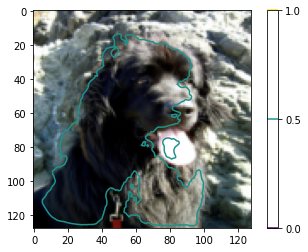

Mean batch loss on validation set: 0.273990 dice: 0.743934
loss: 0.209177 [    0/ 2944]
loss: 0.217423 [  320/ 2944]
loss: 0.181293 [  640/ 2944]
loss: 0.171838 [  960/ 2944]
loss: 0.157267 [ 1280/ 2944]
loss: 0.188838 [ 1600/ 2944]
loss: 0.210962 [ 1920/ 2944]
loss: 0.163679 [ 2240/ 2944]
loss: 0.183606 [ 2560/ 2944]
loss: 0.211014 [ 2880/ 2944]
============= Epoch 25 ===============


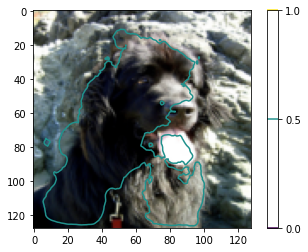

Mean batch loss on validation set: 0.276653 dice: 0.745847
loss: 0.216644 [    0/ 2944]
loss: 0.155621 [  320/ 2944]
loss: 0.170213 [  640/ 2944]
loss: 0.169911 [  960/ 2944]
loss: 0.178642 [ 1280/ 2944]
loss: 0.177561 [ 1600/ 2944]
loss: 0.218050 [ 1920/ 2944]
loss: 0.166704 [ 2240/ 2944]
loss: 0.201405 [ 2560/ 2944]
loss: 0.200206 [ 2880/ 2944]
============= Epoch 26 ===============


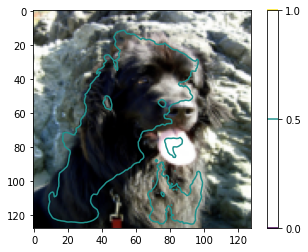

Mean batch loss on validation set: 0.263765 dice: 0.754395
loss: 0.167518 [    0/ 2944]
loss: 0.163985 [  320/ 2944]
loss: 0.205913 [  640/ 2944]
loss: 0.162478 [  960/ 2944]
loss: 0.181688 [ 1280/ 2944]
loss: 0.164169 [ 1600/ 2944]
loss: 0.200003 [ 1920/ 2944]
loss: 0.201778 [ 2240/ 2944]
loss: 0.182079 [ 2560/ 2944]
loss: 0.182587 [ 2880/ 2944]
============= Epoch 27 ===============


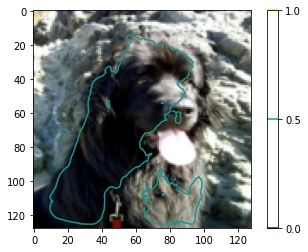

Mean batch loss on validation set: 0.271702 dice: 0.751095
loss: 0.175815 [    0/ 2944]
loss: 0.161609 [  320/ 2944]
loss: 0.165484 [  640/ 2944]
loss: 0.182089 [  960/ 2944]
loss: 0.171144 [ 1280/ 2944]
loss: 0.176110 [ 1600/ 2944]
loss: 0.194184 [ 1920/ 2944]
loss: 0.148983 [ 2240/ 2944]
loss: 0.163454 [ 2560/ 2944]
loss: 0.188805 [ 2880/ 2944]
============= Epoch 28 ===============


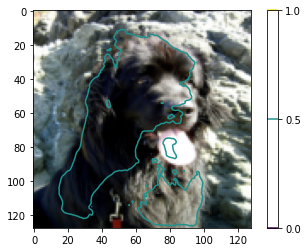

Mean batch loss on validation set: 0.267719 dice: 0.757134
loss: 0.170936 [    0/ 2944]
loss: 0.148294 [  320/ 2944]
loss: 0.180416 [  640/ 2944]
loss: 0.162385 [  960/ 2944]
loss: 0.170621 [ 1280/ 2944]
loss: 0.177354 [ 1600/ 2944]
loss: 0.189402 [ 1920/ 2944]
loss: 0.160446 [ 2240/ 2944]
loss: 0.151230 [ 2560/ 2944]
loss: 0.166328 [ 2880/ 2944]
============= Epoch 29 ===============


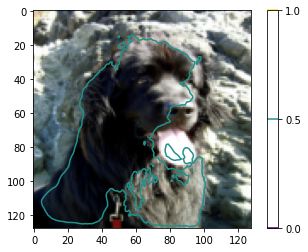

Mean batch loss on validation set: 0.265754 dice: 0.760543
loss: 0.161347 [    0/ 2944]
loss: 0.136221 [  320/ 2944]
loss: 0.166480 [  640/ 2944]
loss: 0.157622 [  960/ 2944]
loss: 0.170367 [ 1280/ 2944]
loss: 0.182908 [ 1600/ 2944]
loss: 0.181697 [ 1920/ 2944]
loss: 0.192339 [ 2240/ 2944]
loss: 0.152207 [ 2560/ 2944]
loss: 0.168447 [ 2880/ 2944]
============= Epoch 30 ===============


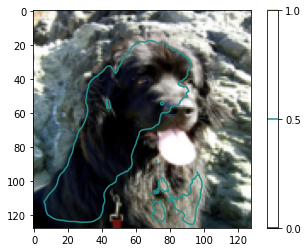

Mean batch loss on validation set: 0.268925 dice: 0.760515
loss: 0.151616 [    0/ 2944]
loss: 0.174851 [  320/ 2944]
loss: 0.148109 [  640/ 2944]
loss: 0.153628 [  960/ 2944]
loss: 0.145813 [ 1280/ 2944]
loss: 0.215378 [ 1600/ 2944]
loss: 0.178695 [ 1920/ 2944]
loss: 0.157017 [ 2240/ 2944]
loss: 0.142662 [ 2560/ 2944]
loss: 0.171482 [ 2880/ 2944]
============= Epoch 31 ===============


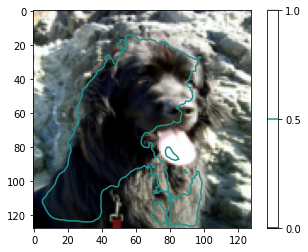

Mean batch loss on validation set: 0.263629 dice: 0.765166
loss: 0.153469 [    0/ 2944]
loss: 0.160689 [  320/ 2944]
loss: 0.168776 [  640/ 2944]
loss: 0.137687 [  960/ 2944]
loss: 0.151118 [ 1280/ 2944]
loss: 0.144999 [ 1600/ 2944]
loss: 0.200538 [ 1920/ 2944]
loss: 0.136805 [ 2240/ 2944]
loss: 0.162307 [ 2560/ 2944]
loss: 0.156249 [ 2880/ 2944]
============= Epoch 32 ===============


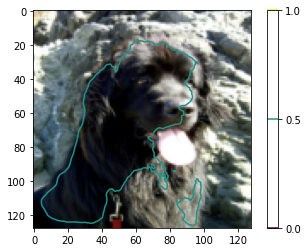

Mean batch loss on validation set: 0.263472 dice: 0.768962
loss: 0.171368 [    0/ 2944]
loss: 0.153709 [  320/ 2944]
loss: 0.165413 [  640/ 2944]
loss: 0.169436 [  960/ 2944]
loss: 0.143542 [ 1280/ 2944]
loss: 0.151265 [ 1600/ 2944]
loss: 0.188752 [ 1920/ 2944]
loss: 0.172674 [ 2240/ 2944]
loss: 0.130274 [ 2560/ 2944]
loss: 0.152013 [ 2880/ 2944]
============= Epoch 33 ===============


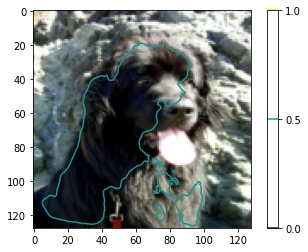

Mean batch loss on validation set: 0.272044 dice: 0.764734
loss: 0.164065 [    0/ 2944]
loss: 0.182021 [  320/ 2944]
loss: 0.183866 [  640/ 2944]
loss: 0.151588 [  960/ 2944]
loss: 0.140497 [ 1280/ 2944]
loss: 0.176998 [ 1600/ 2944]
loss: 0.157451 [ 1920/ 2944]
loss: 0.142050 [ 2240/ 2944]
loss: 0.153258 [ 2560/ 2944]
loss: 0.164705 [ 2880/ 2944]
============= Epoch 34 ===============


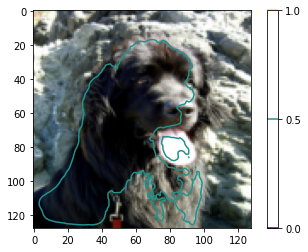

Mean batch loss on validation set: 0.277488 dice: 0.761994
loss: 0.149864 [    0/ 2944]
loss: 0.154467 [  320/ 2944]
loss: 0.206094 [  640/ 2944]
loss: 0.142290 [  960/ 2944]
loss: 0.150268 [ 1280/ 2944]
loss: 0.149681 [ 1600/ 2944]
loss: 0.189496 [ 1920/ 2944]
loss: 0.165309 [ 2240/ 2944]
loss: 0.155491 [ 2560/ 2944]
loss: 0.147688 [ 2880/ 2944]
============= Epoch 35 ===============


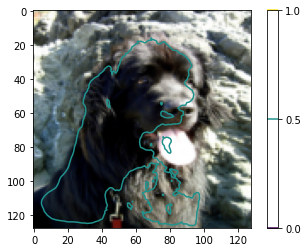

Mean batch loss on validation set: 0.263521 dice: 0.771982
loss: 0.156336 [    0/ 2944]
loss: 0.141587 [  320/ 2944]
loss: 0.149704 [  640/ 2944]
loss: 0.164784 [  960/ 2944]
loss: 0.152583 [ 1280/ 2944]
loss: 0.148320 [ 1600/ 2944]
loss: 0.156353 [ 1920/ 2944]
loss: 0.137649 [ 2240/ 2944]
loss: 0.146019 [ 2560/ 2944]
loss: 0.145880 [ 2880/ 2944]
============= Epoch 36 ===============


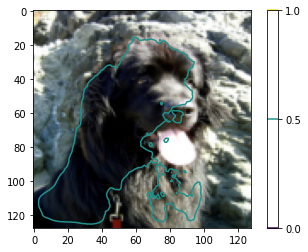

KeyboardInterrupt: 

In [7]:
step = 0

for i in range(hp['epochs']):
    print(f"============= Epoch {i} ===============")
    test_loop(val_dataloader, model, loss_fn, device, step=step, wb=wandb)
    step = train_loop(train_dataloader, model, loss_fn, optimizer, device, step=step, wb=wandb)